In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as opt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('flights_NY.csv')
df.dropna(inplace=True)

In [3]:
df.sample(10)

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
126382,2013,2,18,1100.0,0.0,1349.0,-35.0,DL,N955DL,2261,LGA,MIA,154.0,1096
181669,2013,4,18,1317.0,27.0,1423.0,26.0,B6,N231JB,1006,JFK,BOS,32.0,187
165348,2013,4,1,937.0,-5.0,1230.0,7.0,B6,N565JB,197,JFK,LAS,332.0,2248
142131,2013,3,7,1205.0,21.0,1438.0,4.0,UA,N57111,1690,EWR,MCO,133.0,937
314642,2013,9,6,2049.0,19.0,2149.0,-6.0,WN,N900WN,1707,LGA,MDW,101.0,725
4287,2013,1,5,2027.0,-2.0,2317.0,-13.0,UA,N79279,1,EWR,PBI,148.0,1023
212044,2013,5,21,628.0,-2.0,738.0,-22.0,B6,N358JB,905,JFK,ORD,112.0,740
277275,2013,7,29,1235.0,-2.0,1457.0,-11.0,UA,N24702,1615,EWR,ATL,109.0,746
144095,2013,3,9,1304.0,-4.0,1518.0,-23.0,FL,N982AT,348,LGA,ATL,105.0,762
311770,2013,9,3,2142.0,43.0,2259.0,27.0,EV,N605QX,5048,LGA,RIC,54.0,292


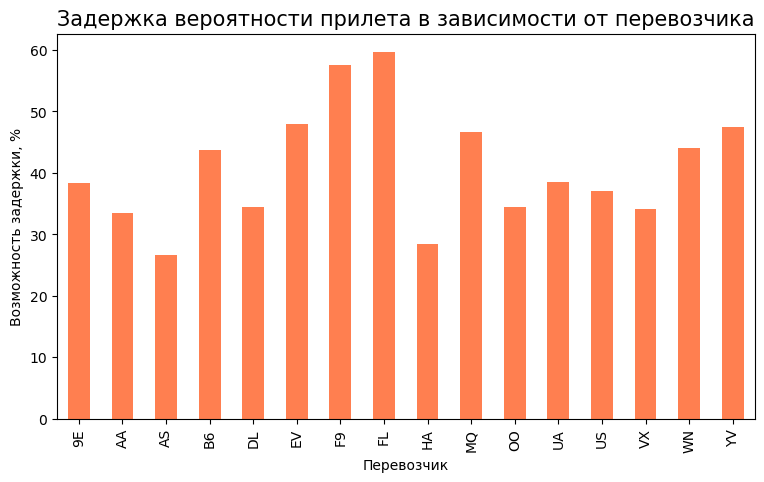

In [4]:
# Вопрос 1. По каждой авиакомпании оцените вероятность того, что задержка прилета будет положительной и нарисуйте график
# показывающий распределение этой вероятности по авиакомпаниям.

delay_probabilities = df.groupby('carrier')['arr_delay'].apply(lambda x: (x > 0).mean())*100

plot = delay_probabilities.plot(kind='bar', color='coral', figsize=(9, 5))
plot.set_ylabel('Возможность задержки, %')
plot.set_xlabel('Перевозчик')
plot.set_title('Задержка вероятности прилета в зависимости от перевозчика', fontsize=15)
plt.show()

flight_dist_cat
Длинные     10.988369
Короткие    12.967937
Средние     13.194758
Name: dep_delay, dtype: float64
LAX    16026
SFO    13173
DEN     7169
IAH     7085
LAS     5952
Name: dest, dtype: int64


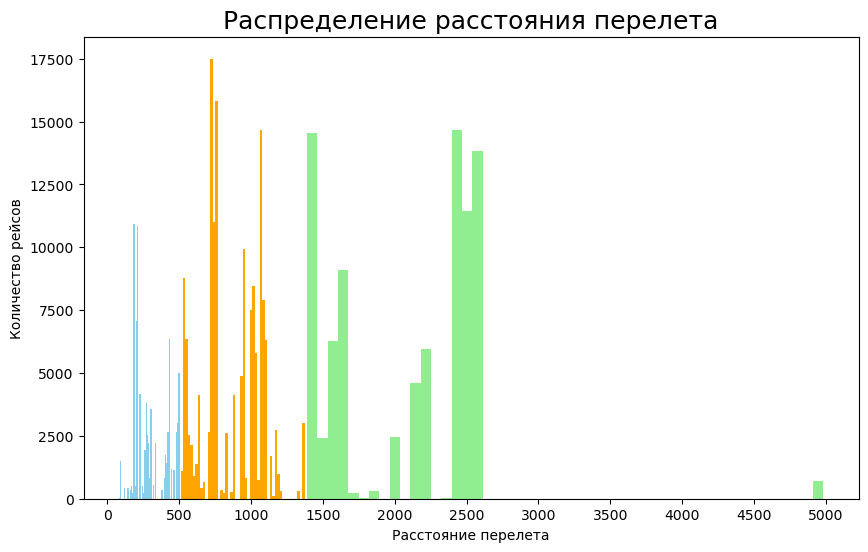

In [5]:
# Вопрос 2. Постройте гистограмму расстояния перелета distance.
# Выделите на ней три группы перелетов: короткие, средние и длинные.
# Какие значения distance разумно выбрать в качестве границы, разделяющей короткие, средние и длинные перелеты?
# Куда летят самолеты в группе длинных перелетов? Найдите среднее время задержки вылета в каждой из трех выделенных групп. 


def categorize(distance):
    if distance < short_dist:
        return 'Короткие'
    elif short_dist <= distance < medium_dist:
        return 'Средние'
    else:
        return 'Длинные'

dist_stats = df['distance'].describe()
Q1 = dist_stats['25%']
Q3 = dist_stats['75%']
short_dist = Q1
medium_dist = Q3
df['flight_dist_cat'] = df['distance'].apply(categorize)
mean_dep_delay_by_category = df.groupby('flight_dist_cat')['dep_delay'].mean()
print(mean_dep_delay_by_category)

print(df[df['flight_dist_cat']=='Длинные']['dest'].value_counts()[0:5])

plt.figure(figsize=(10, 6))
plt.hist(df[df['distance']<Q1]['distance'], bins=50, color='skyblue')
#print(df[df['distance']<Q1]['distance'].count())
plt.hist(df[(df['distance']>=Q1)&(df['distance']<Q3)]['distance'], bins=50, color='orange')
#print(df[(df['distance']>=Q1)&(df['distance']<Q3)]['distance'].count())
plt.hist(df[df['distance']>=Q3]['distance'], bins=50, color='lightgreen')
#print(df[df['distance']>=Q3]['distance'].count())
plt.title('Распределение расстояния перелета', fontsize=18)
plt.xlabel('Расстояние перелета')
plt.locator_params(axis='x', nbins=20)
plt.ylabel('Количество рейсов')
plt.show()

# Было принято решение классифицировать перелеты по длине с помощью квантилей. По диаграмме было не слишком понятно,
# как именно можно поделить перелеты по длине, поэтому я решил выбрать этот метод, приняв,
# что количество перелетов разных классов примерно одинаково.
# Длинные перелеты совершаются, в основном, в Лос-Анджелес, Сан-Франциско, Денвер, Хьюстон и Лас-Вегас.
# Среднее время задержки вылета для рейсов каждой группы представлено ниже.

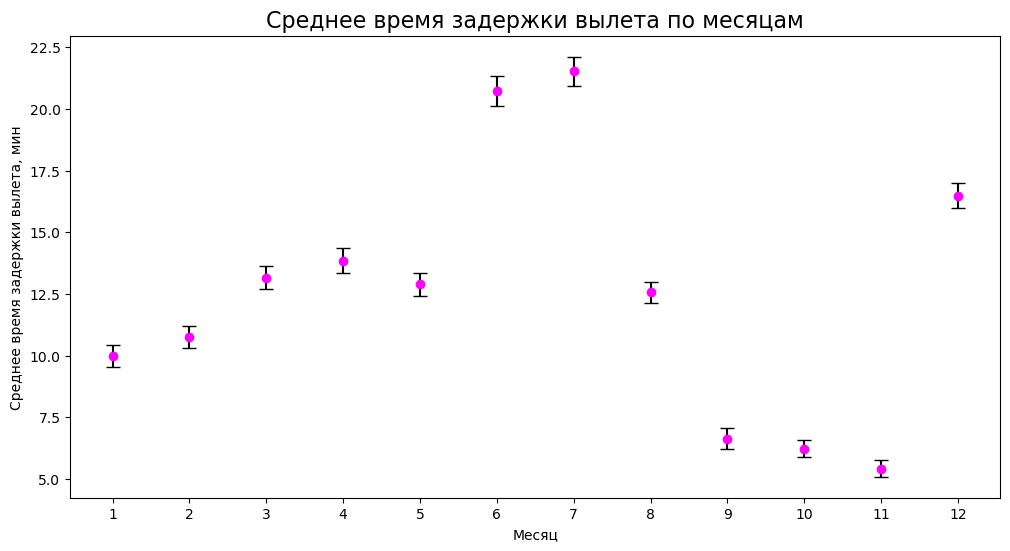

p-значение: 0.017013366495100535


In [6]:
# Вопрос 3. Нарисуйте график среднего времени задержки вылета по месяцам и отметьте на нем границы доверительных интервалов
# с уровнем доверия 0.95. С помощью подходящего статистического теста проверьте,
# можно ли принять гипотезу о равенстве средних в январе и феврале на уровне значимости 0.05?на уровне значимости 0.01? 
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
mean_dep_delay_by_month = df.groupby('month')['dep_delay'].mean()
sem_dep_delay_by_month = df.groupby('month')['dep_delay'].sem()
conf_int = 1.96 * sem_dep_delay_by_month
plt.figure(figsize=(12, 6))
plt.errorbar(x=mean_dep_delay_by_month.index, y=mean_dep_delay_by_month.values, yerr=conf_int.values, fmt='o', color='fuchsia', ecolor='black', capsize=5)
plt.title('Среднее время задержки вылета по месяцам', fontsize=16)
plt.xlabel('Месяц')
plt.locator_params(axis='x', nbins=24)
plt.ylabel('Среднее время задержки вылета, мин')
plt.show()

jan_data = df.loc[df['month'] == 1, 'dep_delay']
feb_data = df.loc[df['month'] == 2, 'dep_delay']
t_stat, p_value = stats.ttest_ind(jan_data, feb_data)
print("p-значение:", p_value)
# Исходя из p-value, можно принять гипотезу о равенстве средних в январе и феврале на уровне значимости 0.01, но не 0.05

Коэффициент корреляции между расстоянием и временем полета: 0.9906496472248587


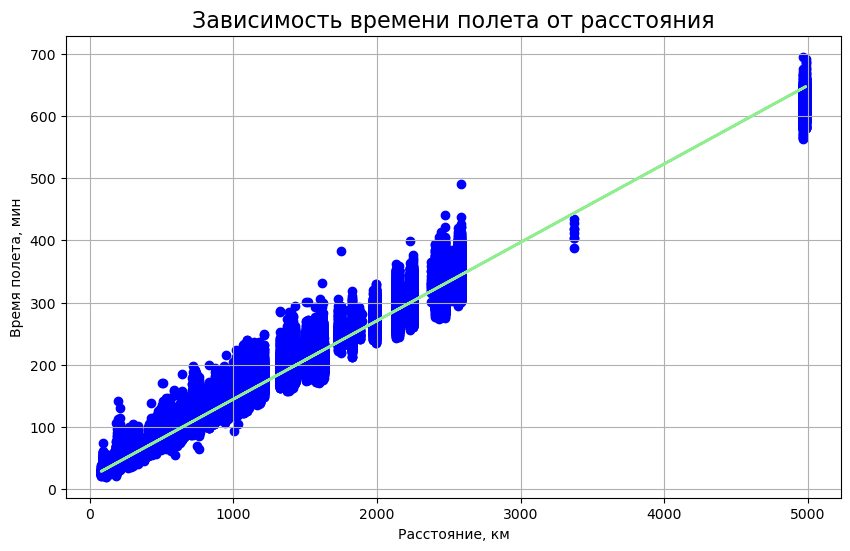

Коэффициенты линейной регрессии:
Угловой коэффициент: 0.1261193246738596
Свободный член: 18.466578127761466


In [7]:
# Вопрос 4. Найдите коэффициент корреляции между расстоянием distance и временем полета air_time.
# Постройте точечную диаграмму в осях distance (х) и air_time (y).
# Найдите коэффициенты линейной регрессии и нанесите полученную прямую на график.
# Как можно интерпретировать смысл коэффициентов полученной линейной модели?
correlation = df['distance'].corr(df['air_time'])
print("Коэффициент корреляции между расстоянием и временем полета:", correlation)

X = df[['distance']]
y = df['air_time']
model = LinearRegression().fit(X, y)
coef = model.coef_
intercept = model.intercept_
plt.figure(figsize=(10, 6))
plt.scatter(df['distance'], df['air_time'], color='blue')
plt.plot(df['distance'], model.predict(X), color='lightgreen', linewidth=2)
plt.title('Зависимость времени полета от расстояния', fontsize=16)
plt.xlabel('Расстояние, км')
plt.ylabel('Время полета, мин')
plt.grid()
plt.show()

print("Коэффициенты линейной регрессии:")
print("Угловой коэффициент:", coef[0])
print("Свободный член:", intercept)
# k - имеет размерность мин/км, т.е. за какое время самолеты в среднем преодолевают 1 км, b - поправочный член,
# формально учитывающий время полета на 0 км

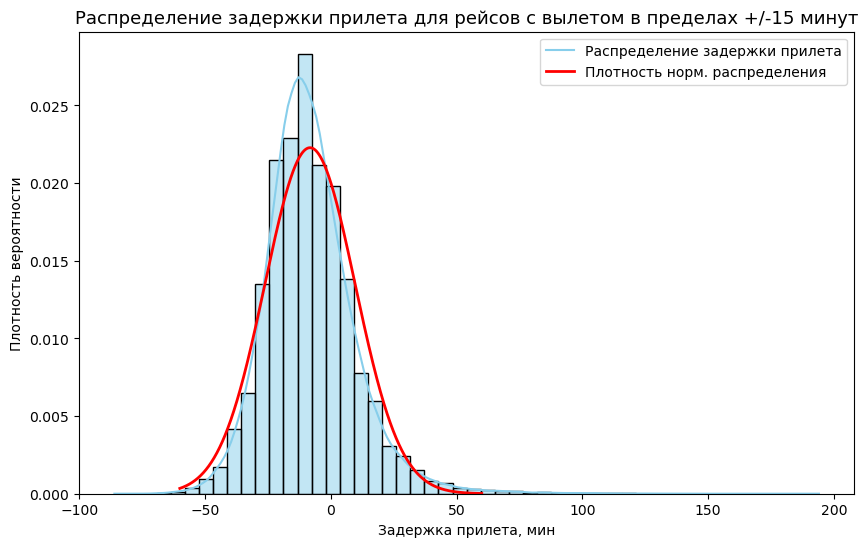

Оценка параметров нормального распределения:
Среднее (μ): -8.251114540466393
Стандартное отклонение (σ): 17.907180068086404


In [8]:
# Вопрос 5. Постройте нормированную гистограмму распределения задержки прилета по тем рейсам, которые вылетели в пределах
# +/-15 минут от времени в расписании. Сделайте предположение о том, каким распределением
# может описываться полученная гистограмма, оцените параметры этого распределения и нанесите график плотности на график
# с гистограммой.
filtered_df = df[(df['dep_delay'] >= -15) & (df['dep_delay'] <= 15)]
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['arr_delay'], bins=50, kde=True, color='skyblue', stat='density')
plt.title('Распределение задержки прилета для рейсов с вылетом в пределах +/-15 минут', fontsize=13)
plt.xlabel('Задержка прилета, мин')
plt.ylabel('Плотность вероятности')
mu, std = stats.norm.fit(data=filtered_df['arr_delay'])
x = np.linspace(-60, 60, 1000)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', linewidth=2)
plt.legend(['Распределение задержки прилета', 'Плотность норм. распределения'])
plt.show()
print("Оценка параметров нормального распределения:")
print("Среднее (μ):", mu)
print("Стандартное отклонение (σ):", std)
# Было предположено, что задержка прилета распределена нормально, судя по форме гистограммы.

In [9]:
# Вопрос 6. Постройте модель логистической регрессии, которая будет предсказывать, что задержка прилета составит более 15 минут. Какие признаки вы будете использовать?
# Какие новые признаки, на основе имеющихся, можете предложить?
# Какова точность полученной модели (precision, recall, accuracy)?
df = pd.read_csv('flights_NY.csv')
df.dropna(inplace=True)
df['delayed'] = (df['arr_delay'] > 15).astype(int)
df['delay_ratio'] = df['arr_delay'] / df['air_time']
df['time_of_day'] = pd.cut(df['dep_time'], bins=[0, 600, 1200, 1800, 2400], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
df = pd.get_dummies(df, columns=['carrier', 'origin', 'dest', 'time_of_day'])
exclude = ['year', 'month', 'day', 'dep_time', 'arr_time', 'tailnum', 'flight', 'air_time', 'arr_delay']
df_subset = df.drop(columns=exclude)
X = df_subset; y = df_subset['delayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# Были предложены следующие признаки: отношение задержки прилета ко времени полета и время дня, в которое совершался вылет.
# Однако, почему-то даже без дополнительных признаков и с удалением признаков, имеющих большую корреляцию с целевым признаком
#(другие, отнсительно удаленных в итоге), модель идеально предсказывает задержку прилета больше 15 минут при любом размере
# тестовой выборки <0.9999 и любом числе итерраций >=40 при размере тестовой выборки 0.3.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74805
           1       1.00      1.00      1.00     23399

    accuracy                           1.00     98204
   macro avg       1.00      1.00      1.00     98204
weighted avg       1.00      1.00      1.00     98204



C:\Users\123\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
